## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

In [1]:
! git clone https://www.github.com/DS3001/kmc

Cloning into 'kmc'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 18
Receiving objects: 100% (25/25), 5.04 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (4/4), done.


**Q1.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

In [6]:
import pandas as pd
df = pd.read_csv('/content/kmc/data/airbnb_hw.csv')

df['price'] = df['Price']
df['beds'] = df['Beds']
df['n_reviews'] = df['Number Of Reviews']
df['score'] = df['Review Scores Rating']
X = df.loc[:,['price','beds','n_reviews','score']]

X['price'].value_counts()
X['price'] = X['price'].str.replace(',','')
X['price'] = pd.to_numeric(X['price'],errors='coerce')

X['beds'] = X['beds'].fillna(1)

pd.crosstab(df['score'].isnull(), df['n_reviews']>0)

X = X.dropna()
X.describe()

,price,beds,n_reviews,score
count,22155.000000,22155.000000,22155.000000,22155.000000
mean,154.787633,1.556985,16.505439,91.993230
std,148.836621,1.043273,24.308241,8.850373
min,10.000000,0.000000,1.000000,20.000000
25%,85.000000,1.000000,2.000000,89.000000
50%,125.000000,1.000000,7.000000,94.000000
75%,190.000000,2.000000,20.000000,100.000000
max,10000.000000,16.000000,257.000000,100.000000


The above code cleans and prepares the data set based on the variables we are given that will be later used to make the plots. For thr price varaible, we removed the "," from and values so we could coerce them to numeric values. For the bed variable, we cleaned it so there was no NA values, and they were filled with a 1. After, the score and review varaibles were crossed tab to get a count of the missing values in the data set. Overall, there were foind to be 509 true missing and 7814 missing values, which are excluded from this analysis, and dropped in the last line of code.

In [8]:
def maxmin(x):
    u = (x-min(x))/(max(x)-min(x))
    return u

Z = X.drop('price',axis=1)
Z = Z.apply(maxmin)

The above code normalizes the price varaible by transforming each value into a number between 0 and 1, which will be its position realtive to the inputed range values of x from the data, in this case the price variable. A new data frame is created removing the price column, and then applying the tranforming function to the new data frame based on the value returned from the maxmin function.

In [9]:
from sklearn.cluster import KMeans # Import kmc
import matplotlib.pyplot as plt


model = KMeans(n_clusters=6, max_iter=300, n_init = 10, random_state=0) # Create a model for
model = model.fit(Z) # Fit the emodel
Z['cluster'] = model.labels_

The above code uses the data frame Z from the question above in order to apply the K means clustering technique. The model is set up to form 6 clusters, iterate 300 times, iterate the alrothims through 10 different seeds, and set a random seed for reproducabilty. Based on the emodel created from the kmeans algorithm, a new column is then added to the data frame Z which has the assigned cluster labels for the values in the dataset.

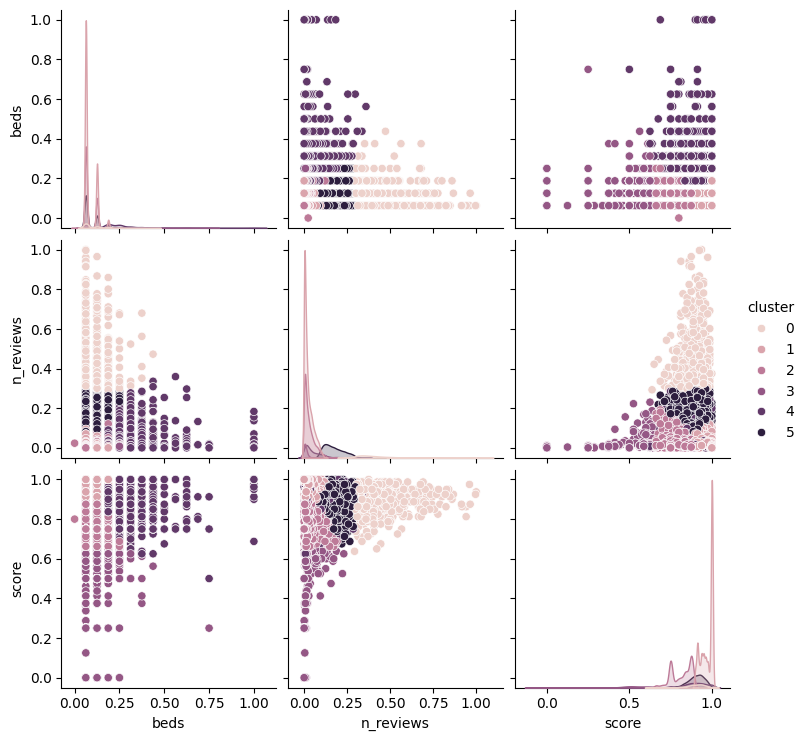

In [10]:
import seaborn as sns
sns.pairplot(data=Z,hue='cluster')

The above code created scatter plots showing correlations bewteen each varaible in the data set, specifying clsuter based on the hue on the scatter plot points.

In [11]:
X['cluster'] = model.labels_
X.loc[:,['price','cluster'] ].groupby('cluster').describe()

price                                                              
           count        mean         std   min     25%    50%     75%      max
cluster                                                                       
0          794.0  133.238035   83.077776  27.0   80.00  110.0  168.50    875.0
1        10512.0  152.233352  147.281729  10.0   85.00  130.0  190.00  10000.0
2         5554.0  131.496579  102.621585  20.0   75.00  110.0  169.00   5000.0
3          632.0  133.587025  215.505565  25.0   65.00   99.0  151.25   5000.0
4         1633.0  293.458665  262.439199  27.0  150.00  229.0  350.00   4500.0
5         3030.0  141.674917   84.134011  22.0   87.25  125.0  175.00   1000.0

The above code adds a new column to the data set representing the cluster number for each value. The code then extracts those two varaibles from the data set, and desribes the data set based on the observations found in each cluster.

Cluster 4 appears to have the highest rental prices, having a mean atleast $140 higher than each of the other clusters. Cluster 0 and 3 have very similar medians, right around 132, with clsuter 2 being slightly belowe at 131. The other two clsuters also have means that are similar to those other than clsuter 4, with the cluster 1 median being around 152, and clsuter 5, 141.

**Q2.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans # Import kmc
import matplotlib.pyplot as plt

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

<Axes: xlabel='x1', ylabel='x2'>

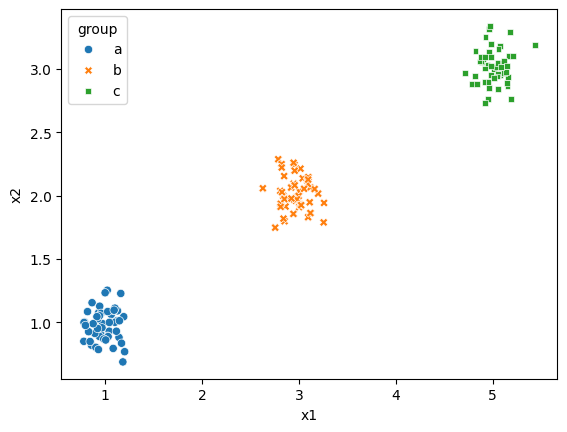

In [14]:
sns.scatterplot(data = df0_125, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

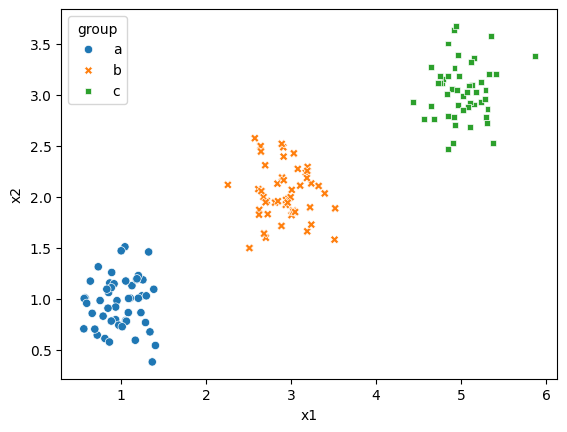

In [15]:
sns.scatterplot(data = df0_25, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

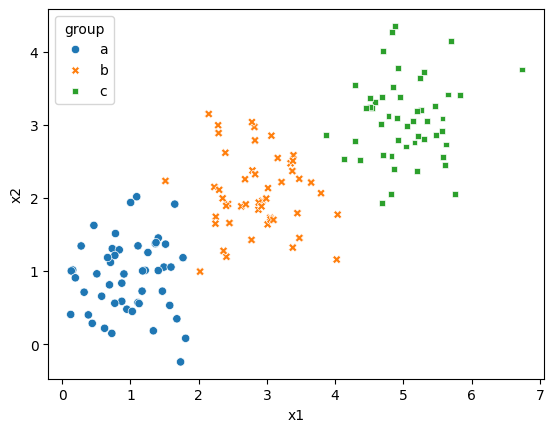

In [16]:
sns.scatterplot(data = df0_5, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

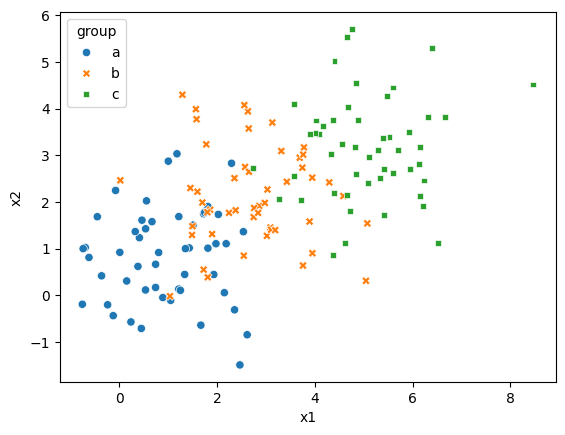

In [17]:
sns.scatterplot(data = df1_0, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

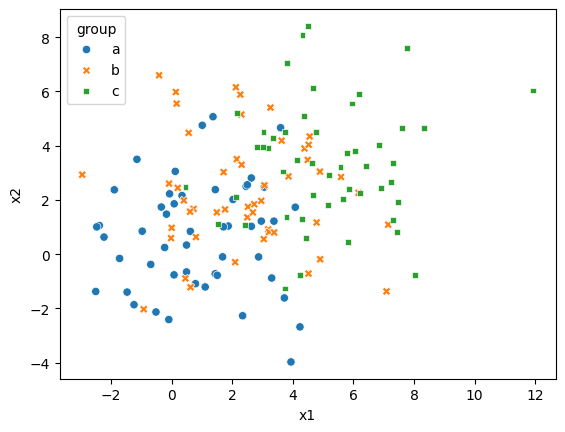

In [18]:
sns.scatterplot(data = df2_0, x = 'x1',y='x2',hue='group',style='group')

going back to this

**Q3.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?